Рассмотрим мультивариативный ряд

Данные представляют собой историю цен и объемы торгов пятидесяти акций индекса NIFTY 50 от NSE (Национальной фондовой биржи) Индии. Все наборы данных представлены на уровне дня, а цены и торговые значения разделены по файлам .csv для каждой акции. Данные охватывают период с 1 января 2000 г. по 30 апреля 2021 г.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [23]:
df = pd.read_csv("bebra.csv")
df = df.drop(df.columns[:3], axis=1)
df = df.fillna(df.mean())

df.head()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,361.20,370.0,390.0,370.0,385.0,381.65,380.54,3318,1.262617e+11,41346.011401,275128.103398,0.625572
1,381.65,380.0,392.0,375.0,390.0,385.55,383.50,4818,1.847699e+11,41346.011401,275128.103398,0.625572
2,385.55,371.5,390.0,371.5,383.0,383.00,379.81,2628,9.981384e+10,41346.011401,275128.103398,0.625572
3,383.00,384.9,384.9,374.5,375.1,377.50,379.88,3354,1.274114e+11,41346.011401,275128.103398,0.625572
4,377.50,376.0,390.0,370.0,389.0,385.70,383.38,9589,3.676275e+11,41346.011401,275128.103398,0.625572


In [24]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,5306.000000,5.306000e+03,5306.000000
mean,1247.000952,1247.683952,1264.625349,1230.900697,1247.317132,1247.410903,1247.799926,5.096721e+05,6.942919e+13,41346.011401,2.751281e+05,0.625572
std,1074.399506,1074.025577,1087.238871,1062.629409,1074.432667,1074.476439,1075.057438,8.535993e+05,1.443973e+14,24786.042419,3.952988e+05,0.178371
min,210.750000,210.000000,215.750000,204.000000,210.600000,210.750000,212.220000,2.500000e+01,1.278415e+09,70.000000,2.500000e+01,0.076800
25%,415.737500,415.000000,424.950000,410.000000,416.000000,416.262500,415.692500,1.370750e+04,7.538133e+11,35008.500000,1.473900e+04,0.502000
50%,889.375000,890.000000,903.975000,878.075000,890.000000,889.475000,888.350000,5.713600e+04,1.109437e+13,41346.011401,8.676800e+04,0.625572
75%,1599.037500,1599.800000,1629.675000,1573.037500,1602.500000,1600.762500,1600.982500,8.077905e+05,7.761479e+13,41346.011401,4.003875e+05,0.749350
max,5213.100000,5221.100000,5247.750000,5150.050000,5221.100000,5213.100000,5175.790000,1.154594e+07,2.216650e+15,351347.000000,7.938427e+06,1.000000


In [25]:
df.dtypes

Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                  int64
Turnover              float64
Trades                float64
Deliverable Volume    float64
%Deliverble           float64
dtype: object

In [26]:
df.columns

Index(['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume',
       'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble'],
      dtype='object')

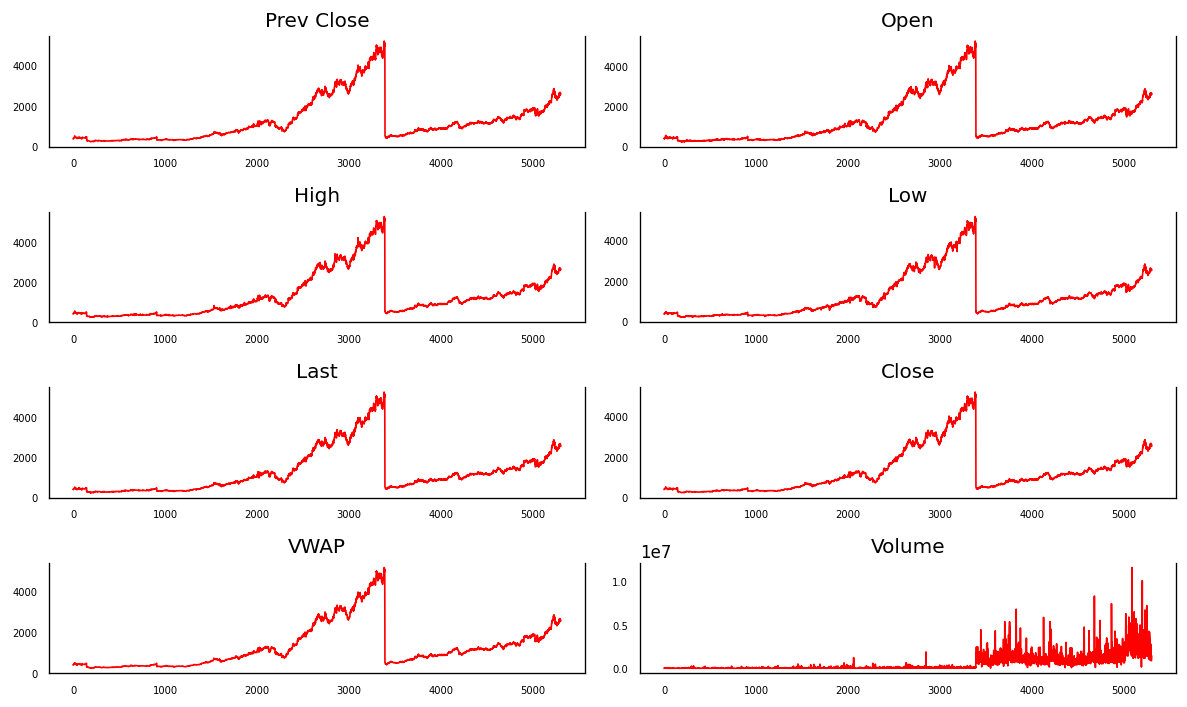

In [27]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [28]:
# Проверяем стационарность

from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = df.drop([ 'Prev Close'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

array([3.50296176e-01, 3.41465759e-01, 3.33323963e-01, 3.03562236e-01,
       2.34730980e-01, 1.73497564e-01, 1.23457827e-01, 4.81014384e-02,
       3.54887772e-02, 6.22422306e-03, 2.19726412e-04])

In [31]:
# granger causality tests

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Проверка причинности Грейнджера для всех возможных комбинаций временных рядов.
    Строки представляют зависимую переменную, столбцы - предикторы. Значения в таблице
    представляют собой P-значения. P-значения меньше уровня значимости (0.05) означают,
    что нулевая гипотеза о том, что коэффициенты соответствующих прошлых значений равны
    нулю, то есть, X не вызывает Y, может быть отвергнута.
    data      : pandas dataframe, содержащий переменные временных рядов
    variables : список, содержащий имена переменных временных рядов.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose:
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [32]:
grangers_causation_matrix(df, variables = df.columns)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

InfeasibleTestError: ignored

# Коинтегральность

Когда два или более временных ряда коинтегрированы, это означает, что они имеют долгосрочную, статистически значимую связь.

Это основная предпосылка, на которой основаны модели векторной авторегрессии (VAR).
Итак, довольно часто перед началом построения VAR-моделей проводят тест на коинтеграцию.

более технически:
Порядок интегрирования (d) — это не что иное, как количество разностей, необходимое для того,
чтобы сделать нестационарный временной ряд стационарным.

Теперь, когда у вас есть два или более временных ряда и существует их линейная комбинация,
у которой порядок интегрирования (d) меньше, чем у отдельного ряда, тогда совокупность рядов называется коинтегрированной.

In [33]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [34]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Prev Close ::  12697.34  > 311.1288  =>   True
Open   ::  4165.11   > 263.2603  =>   True
High   ::  3249.11   > 219.4051  =>   True
Low    ::  2426.06   > 179.5199  =>   True
Last   ::  1633.72   > 143.6691  =>   True
Close  ::  957.95    > 111.7797  =>   True
VWAP   ::  488.03    > 83.9383   =>   True
Volume ::  213.82    > 60.0627   =>   True
Turnover ::  108.01    > 40.1749   =>   True
Trades ::  42.79     > 24.2761   =>   True
Deliverable Volume ::  5.11      > 12.3212   =>   False
%Deliverble ::  0.04      > 4.1296    =>   False


In [35]:
# Стационарность
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [36]:
# Разделяем выборку на трейн и тест
#creating the train and validation set
train = df[:int(0.8*(len(data)))]
test = df[int(0.8*(len(data))):]

In [37]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Prev Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.056
 No. Lags Chosen       = 9
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.2626. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0619
 No. Lags Chosen       = 8
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.2601. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [38]:
# если нестационарный, то удаляем тренд (помните дифференцирование ?) и опять проверяеми
# 1st difference
df_differenced = train.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Prev Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -22.5662
 No. Lags Chosen       = 8
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.8178
 No. Lags Chosen       = 7
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [39]:
# если опять нестационарные - опять дифференцируем


df_differenced = df_differenced.diff().dropna()

# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Prev Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.1951
 No. Lags Chosen       = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.3951
 No. Lags Chosen       = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

In [40]:
# Чтобы выбрать правильный порядок модели VAR, мы итеративно подбираем возрастающие порядки модели VAR и выбираем порядок, который дает модель с наименьшим AIC.

from statsmodels.tsa.vector_ar.var_model import VAR


model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  108.68405334034782
BIC :  108.91772428626577
FPE :  1.5881251984426656e+47
HQIC:  108.76663787942657 

Lag Order = 2
AIC :  127.7383061288958
BIC :  128.18776262994953
FPE :  2.9925553488609203e+55
HQIC:  127.89715601155132 

Lag Order = 3
AIC :  154.77148015348152
BIC :  155.4368079916699
FPE :  1.645894891090557e+67
HQIC:  155.00662752441318 

Lag Order = 4
AIC :  155.9565500540015
BIC :  156.83783506637315
FPE :  5.3836209640509134e+67
HQIC:  156.26802707914197 

Lag Order = 5
AIC :  155.58834917026536
BIC :  156.68567724896693
FPE :  3.725391010090064e+67
HQIC:  155.97618803679964 

Lag Order = 6
AIC :  154.9969265878758
BIC :  156.3103836802006
FPE :  2.0621854296028326e+67
HQIC:  155.46115950426025 

Lag Order = 7
AIC :  153.09960353943046
BIC :  154.62927564786682
FPE :  3.0927235173894897e+66
HQIC:  153.64026273541185 

Lag Order = 8
AIC :  153.50797228584082
BIC :  155.25394546812063
FPE :  4.652721762197971e+66
HQIC:  154.12509001247545 

Lag Order = 9
AI

In [41]:
# другой вариает - автозаполнение. Лучшие метрики выделены *

x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,179.0,179.0,5.438e+77,179.0
1,106.7*,106.9*,2.216e+46*,106.8*
2,129.6,130.1,1.951e+56,129.8
3,156.1,156.8,6.254e+67,156.3
4,155.9,156.7,4.909e+67,156.2
5,155.2,156.3,2.461e+67,155.6
6,152.9,154.2,2.498e+66,153.4
7,154.7,156.2,1.462e+67,155.2
8,153.5,155.2,4.480e+66,154.1
9,153.4,155.4,4.383e+66,154.1


In [42]:
# заполняем модель с лучшими параметрами
model_fitted = model.fit(12)
model_fitted.summary()

LinAlgError: ignored

In [43]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

# for col, val in zip(df.columns, out):
#    print(adjust(col), ':', round(val, 2))

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Prev Close : 1.89
Open : 2.0
High : 2.0
Low : 2.0
Last : 2.01
Close : 2.01
VWAP : 2.0
Volume : 2.05
Turnover : 2.05
Trades : 2.04
Deliverable Volume : 2.04
%Deliverble : 2.3


In [44]:
# получаем значение лага
lag_order = model_fitted.k_ar
print(lag_order)

12


In [45]:
# данные для предсказания
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 1.44000000e+01,  6.20000000e+00,  1.94000000e+01,
         2.75000000e+00, -8.60000000e+00, -8.50000000e+00,
         1.24500000e+01,  7.13391000e+05,  6.35735833e+13,
         1.88470000e+04,  2.54285000e+05, -2.45000000e-02],
       [-8.50000000e+00, -1.10000000e+00, -1.52000000e+01,
         1.30000000e+00,  4.20000000e+00,  4.65000000e+00,
        -1.20300000e+01, -1.37339000e+05, -1.31792575e+13,
         9.20500000e+03,  1.34783000e+05,  1.56000000e-01],
       [ 4.65000000e+00,  2.95000000e+00,  1.10000000e+01,
        -1.95000000e+00,  5.90000000e+00,  6.65000000e+00,
         1.03700000e+01, -3.77210000e+05, -3.22599670e+13,
        -1.98110000e+04, -5.04134000e+05, -2.73800000e-01],
       [ 6.65000000e+00,  2.10000000e+00,  4.50000000e+00,
        -5.75000000e+00,  4.10000000e+00,  2.60000000e+00,
        -1.81000000e+00,  3.63672000e+05,  3.20455523e+13,
        -3.70300000e+03,  3.00401000e+05,  1.03900000e-01],
       [ 2.60000000e+00,  8.95000000e+00, -1.0000000

In [46]:
# Forecast
nobs = 20 # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Prev Close_2d,Open_2d,High_2d,Low_2d,Last_2d,Close_2d,VWAP_2d,Volume_2d,Turnover_2d,Trades_2d,Deliverable Volume_2d,%Deliverble_2d
5286,-12.070613,1.036057,15.183258,1.970886,13.556176,13.383584,7.793736,659749.595021,6.314646e+13,16548.313775,507925.029989,0.104839
5287,13.389403,-6.650463,-14.197985,-2.674213,-11.559487,-15.045375,-11.980741,-230321.969623,-2.591090e+13,-4826.749831,-225797.324670,-0.043666
5288,-15.204137,-2.795924,3.296377,-3.048287,4.647485,11.016754,6.928694,-154702.922759,-9.394358e+12,169.393813,-170515.362395,-0.113327
5289,10.941586,-0.208596,1.247601,-2.625320,-5.457323,-7.352350,-3.176467,102142.440839,9.115501e+12,-351.812890,84850.400089,0.069580
5290,-7.301195,12.649689,7.235256,14.282052,9.225940,7.532863,7.905133,-149934.684309,-1.534449e+13,564.083309,585.007757,-0.029967
5291,7.590153,1.990115,5.363848,1.861374,7.137625,8.043919,6.184005,124353.725921,1.160659e+13,-1995.042405,-42515.831548,0.071089
5292,8.017373,-15.147195,-20.519708,-17.262162,-17.527255,-17.618127,-18.746868,-289733.574857,-2.770780e+13,-3113.581039,-42798.061992,-0.121873
5293,-17.616410,6.169110,9.043602,9.907529,2.063360,2.878531,7.028030,243078.445393,2.299144e+13,-1040.787803,100985.430049,0.127289
5294,2.879969,-0.405971,-0.827332,-1.088387,6.997003,6.147806,0.598644,-123830.429049,-1.074485e+13,3165.913658,-117701.547869,-0.062511
5295,6.141705,-0.884000,-3.364561,-3.328234,-5.786090,-6.852963,-3.250526,19302.604967,1.920777e+12,-1234.796689,71721.130671,0.030231


In [47]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [48]:
cl = ["Prev Close_2d", "Open_2d", "High_2d", "Low_2d", "Last_2d", "Close_2d", "VWAP_2d", "Volume_2d", "Turnover_2d", "Trades_2d", "Deliverable Volume_2d", "%Deliverble_2d"]
df_results = invert_transformation(train, df_forecast, second_diff=True)
df_results.loc[:, cl]

,Prev Close_2d,Open_2d,High_2d,Low_2d,Last_2d,Close_2d,VWAP_2d,Volume_2d,Turnover_2d,Trades_2d,Deliverable Volume_2d,%Deliverble_2d
5286,-12.070613,1.036057,15.183258,1.970886,13.556176,13.383584,7.793736,659749.595021,6.314646e+13,16548.313775,507925.029989,0.104839
5287,13.389403,-6.650463,-14.197985,-2.674213,-11.559487,-15.045375,-11.980741,-230321.969623,-2.591090e+13,-4826.749831,-225797.324670,-0.043666
5288,-15.204137,-2.795924,3.296377,-3.048287,4.647485,11.016754,6.928694,-154702.922759,-9.394358e+12,169.393813,-170515.362395,-0.113327
5289,10.941586,-0.208596,1.247601,-2.625320,-5.457323,-7.352350,-3.176467,102142.440839,9.115501e+12,-351.812890,84850.400089,0.069580
5290,-7.301195,12.649689,7.235256,14.282052,9.225940,7.532863,7.905133,-149934.684309,-1.534449e+13,564.083309,585.007757,-0.029967
5291,7.590153,1.990115,5.363848,1.861374,7.137625,8.043919,6.184005,124353.725921,1.160659e+13,-1995.042405,-42515.831548,0.071089
5292,8.017373,-15.147195,-20.519708,-17.262162,-17.527255,-17.618127,-18.746868,-289733.574857,-2.770780e+13,-3113.581039,-42798.061992,-0.121873
5293,-17.616410,6.169110,9.043602,9.907529,2.063360,2.878531,7.028030,243078.445393,2.299144e+13,-1040.787803,100985.430049,0.127289
5294,2.879969,-0.405971,-0.827332,-1.088387,6.997003,6.147806,0.598644,-123830.429049,-1.074485e+13,3165.913658,-117701.547869,-0.062511
5295,6.141705,-0.884000,-3.364561,-3.328234,-5.786090,-6.852963,-3.250526,19302.604967,1.920777e+12,-1234.796689,71721.130671,0.030231


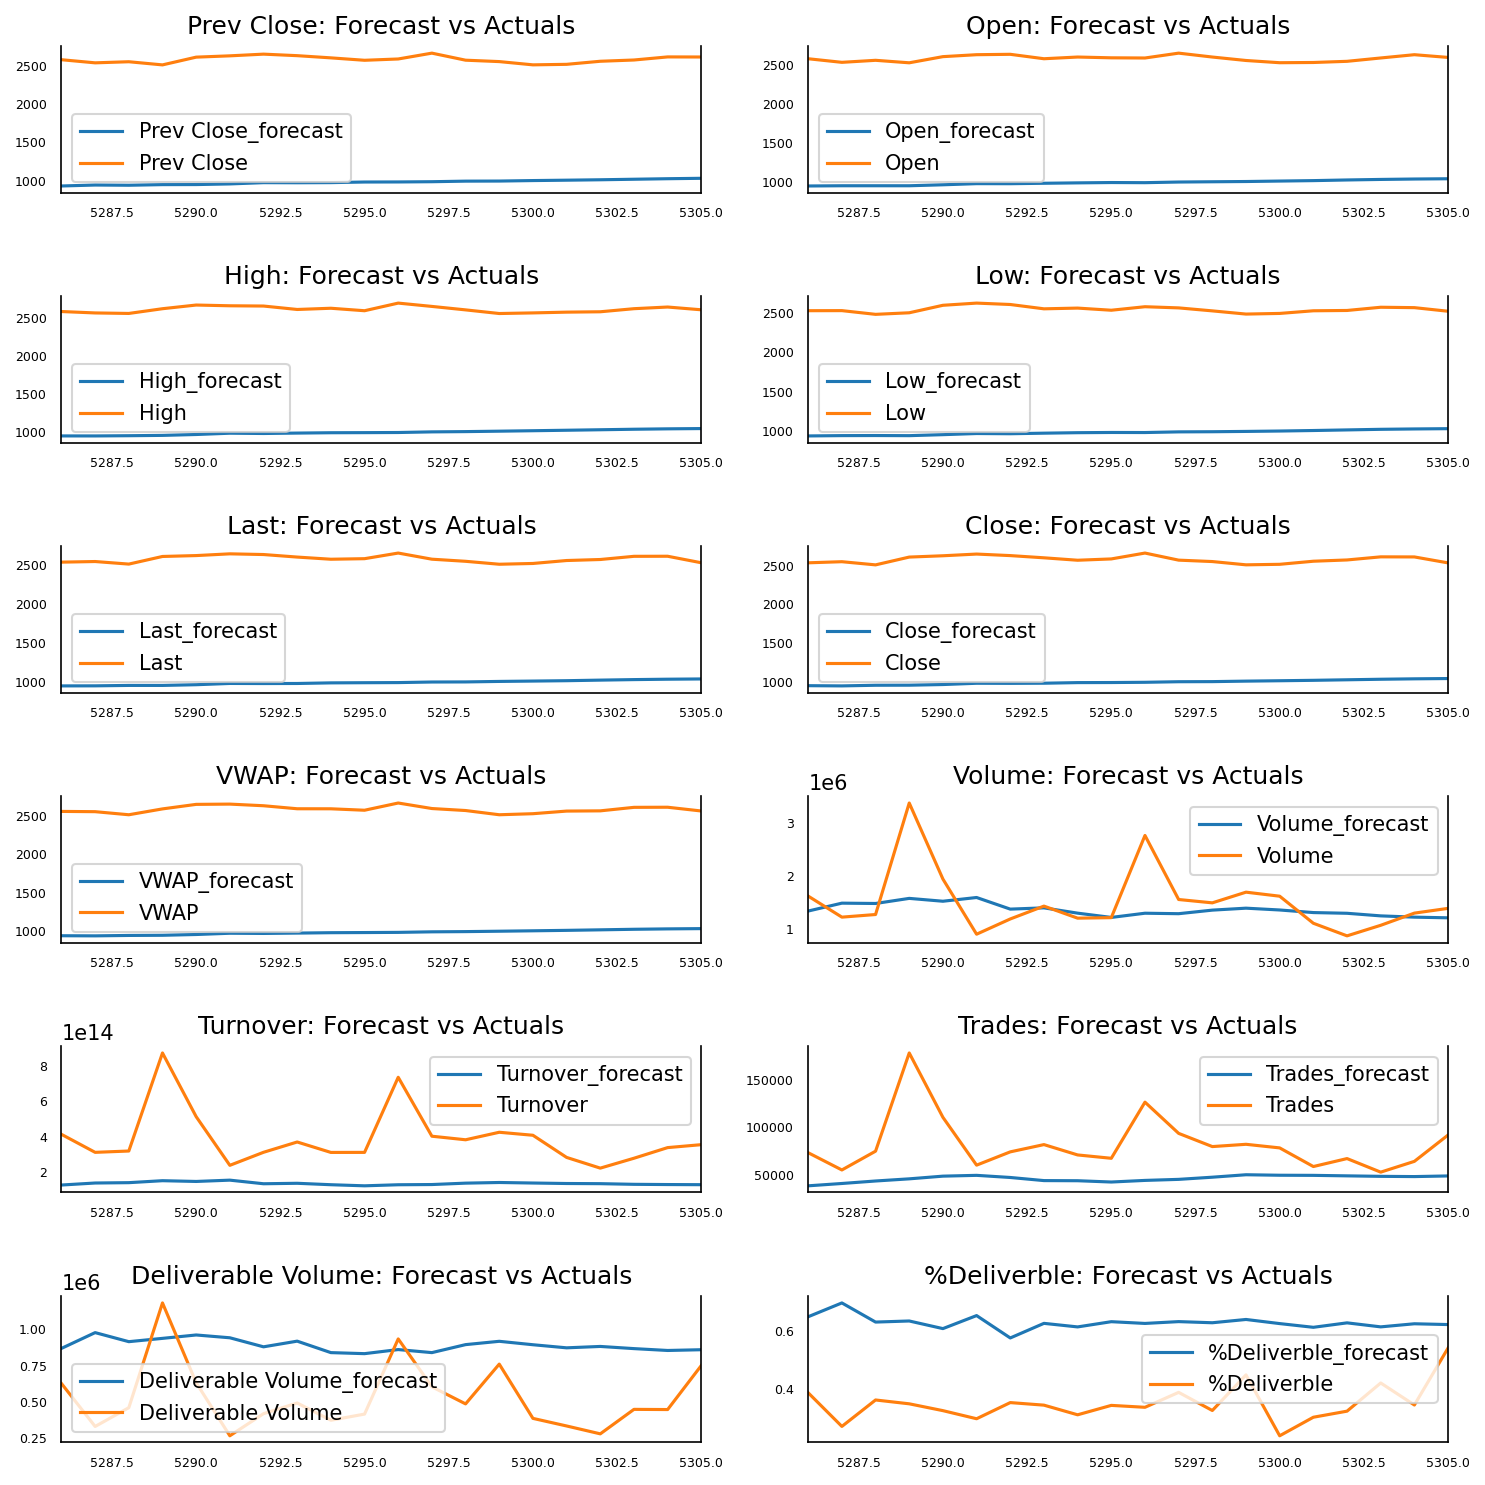

In [49]:
# отрисовываем


fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [50]:
# Метрики!

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [51]:
cols = test.columns.to_list()

for vi in range(len(cols)):
    print(f'Forecast Accuracy of: {cols[vi]}')
    n1 = f"{cols[vi]}_forecast"
    accuracy_prod = forecast_accuracy(df_results[n1].values, np.array(test.iloc[len(test) - 20: len(test),vi]))
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))

Forecast Accuracy of: Prev Close
mape :  0.6187
me :  -1597.7939
mae :  1597.7939
mpe :  -0.6187
rmse :  1598.6111
corr :  0.0497
minmax :  0.6187
Forecast Accuracy of: Open
mape :  0.617
me :  -1593.3609
mae :  1593.3609
mpe :  -0.617
rmse :  1593.9585
corr :  0.1455
minmax :  0.617
Forecast Accuracy of: High
mape :  0.617
me :  -1611.5101
mae :  1611.5101
mpe :  -0.617
rmse :  1612.2543
corr :  0.0157
minmax :  0.617
Forecast Accuracy of: Low
mape :  0.6161
me :  -1569.4108
mae :  1569.4108
mpe :  -0.6161
rmse :  1570.1489
corr :  0.0089
minmax :  0.6161
Forecast Accuracy of: Last
mape :  0.6169
me :  -1590.445
mae :  1590.445
mpe :  -0.6169
rmse :  1591.3214
corr :  -0.0471
minmax :  0.6169
Forecast Accuracy of: Close
mape :  0.6162
me :  -1590.0391
mae :  1590.0391
mpe :  -0.6162
rmse :  1590.969
corr :  -0.0448
minmax :  0.6162
Forecast Accuracy of: VWAP
mape :  0.6173
me :  -1593.0472
mae :  1593.0472
mpe :  -0.6173
rmse :  1593.8828
corr :  -0.0182
minmax :  0.6173
Forecast Accu